## __Análisis de choques en principales vialidades con API de Goolge Maps__<br>

Incidentes viales reportados por C5 de la Ciudad de México

Base a utilizar: https://datos.cdmx.gob.mx/dataset/incidentes-viales-c5
    
    

In [1]:
## Cargamos las paqueterías que vamos a utilizar


import pandas as pd 
import numpy as np
from math import pi

import matplotlib.pyplot as plt 
import matplotlib as mpl
import seaborn as sns


import geopandas as gpd # Es recomendable instalar desde Anaconda: conda install geopandas
import geoplot as gplt # Se recomienda instalar en Anaconda: conda install -c conda-forge geoplot
import geoplot.crs as gcrs
from shapely.geometry import  LineString, Point # pip install Shapely
import shapefile as shp
import json
import itertools


from tqdm import tqdm

import googlemaps # pip install googlemaps


import urllib.request

import glob
import os

import warnings
warnings.filterwarnings('ignore')

## Índice

1. [Carga y descarga de base de incidentes viales del C5](#1.-Carga-y-descarga-de-base-de-incidentes-viales-del-C5)<br>
2. [Filtro y limpia de la base de datos](#2.-Filtro-y-limpia-de-la-base-de-datos)<br>
3. [Exploración de la base](#3.-Exploración-de-la-base)<br>
4. [Presentación de resultados](#4.-Presentación-de-resultados)<br>
    4.1. [4.1 Alcaldía con más eventos](#4.1-Alcaldía-con-más-eventos)<br>
    4.1.1 [Visualización gráfica de los incidentes por Alcaldía](#4.4.1-Visualización-gráfica-de-los-incidentes-por-Alcaldía)<br>
    4.2  [Días con más incidentes](#4.2-Días-con-más-incidentes)<br>
    4.3 [Hora con más incidentes](#4.3-Hora-con-más-incidentes)<br>
    4.4 [Calles con más incidentes](#4.4-Calles-con-más-incidentes)<br>
    4.5 [Esquinas en donde suceden más incidentes](#4.5-Esquinas-en-donde-suceden-más-incidentes)<br>
    
    

## 1. Carga y descarga de base de incidentes viales del C5

In [2]:

## Creamos el directorio donde guardaremos la base de los incidentes del C5
if not os.path.isdir('incidentes_c5'):
    os.makedirs('incidentes_c5')

        
## Verificamos que la base de datos ya se encuentre en la carpeta y cargamos la base de datos
if r'incidentes_c5\incidentes-viales-c5.csv' not in glob.glob(r'incidentes_c5\*'):
    
    print("Descargando base de incidentes viales...")

    enlace = 'https://archivo.datos.cdmx.gob.mx/incidentes-viales-c5.csv'
    
    urllib.request.urlretrieve(enlace, r"incidentes_c5\incidentes-viales-c5.csv")
    
    print("Descarga finalizada")
    
## Cargamos la base de datos
incidentes = pd.read_csv(r'incidentes_c5\incidentes-viales-c5.csv',
                         engine='python', encoding='utf_8')



# 2. Filtro y limpia de la base de datos

Conforme se menciona en el portal del Datos Abiertos de la Ciudad de México, para contabilizar aquellos incidentes “reales”, es decir, aquellos confirmados por las autoridades en el lugar de los hechos, se debe trabajar con los códigos de cierre “Afirmativo”.

Por lo que primero filtramos la base con aquellos códigos Afirmativos, es decir, los que comienzan con "(A)" en la columna de codigo_cierre.

Por otro lado, los formatos de fecha_creacion cambian para algunas filas: la mayoría contiene el formato "dd/mm/yyyy", pero en algunas filas el formato pasa a ser "dd/mm/yy", por lo que se harán las conversiones de los dos formatos.

Asimismo, de la columna hora_creacion, el formato en la mayoría de las observaciones es"H:M:S", pero en pocas filas el formato está en decimales, por lo que se aplica una conversión.

In [3]:
## Filtramos la base
incidentes = incidentes[incidentes["codigo_cierre"].str.startswith('(A)')]

## Convertimos las columnas de fecha_creación y hora_creación en formato datetime para analizar cuándo fueron los hechos
incidentes["fecha_hecho"] = pd.to_datetime(incidentes["fecha_creacion"], errors='coerce', 
                                          format= "%d/%m/%Y").copy()

## Se convierten las filas con formato diferente
incidentes.loc[incidentes["fecha_hecho"].isna(),"fecha_hecho"] = pd.to_datetime(incidentes["fecha_creacion"], 
                                                                             errors='coerce', format= "%d/%m/%y").copy()
## Convertimos la columna de hora_creacion a datetime
incidentes["hora_hecho"] = pd.to_datetime(incidentes["hora_creacion"], errors='coerce', 
                                          format= "%H:%M:%S").copy()

## Se convierten las filas con formato decimal
incidentes.loc[incidentes["hora_hecho"].isna(),"hora_creacion"] = \
incidentes.loc[incidentes["hora_hecho"].isna(),"hora_creacion"].apply(lambda x: "{:02d}:{:02d}:{:02d}"\
                                                                      .format(int(float(x)*24), 
                                                                              int((float(x)%1)*60), 
                                                                              int((((float(x)%1)*60)%1)*60)))

## Volvemos a convertir la columna de hora_creacion a datetime
incidentes["hora_hecho"] = pd.to_datetime(incidentes["hora_creacion"], errors='coerce', 
                                          format= "%H:%M:%S").copy()



In [4]:
## Exploramos la base de datos
incidentes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610165 entries, 0 to 1412330
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 610165 non-null  int64         
 1   folio              610165 non-null  object        
 2   fecha_creacion     610165 non-null  object        
 3   hora_creacion      610165 non-null  object        
 4   dia_semana         610165 non-null  object        
 5   codigo_cierre      610165 non-null  object        
 6   fecha_cierre       610165 non-null  object        
 7   ano                610165 non-null  int64         
 8   mesdecierre        610165 non-null  object        
 9   hora_cierre        610165 non-null  object        
 10  delegacion_inicio  610155 non-null  object        
 11  incidente_c4       610165 non-null  object        
 12  latitud            610034 non-null  float64       
 13  longitud           610036 non-null  float64

In [5]:
# Vemos los valores nulos de la base
incidentes.isna().sum(axis=0)

id                     0
folio                  0
fecha_creacion         0
hora_creacion          0
dia_semana             0
codigo_cierre          0
fecha_cierre           0
ano                    0
mesdecierre            0
hora_cierre            0
delegacion_inicio     10
incidente_c4           0
latitud              131
longitud             129
clas_con_f_alarma      0
tipo_entrada           0
delegacion_cierre      0
geopoint             133
mes                    0
fecha_hecho            0
hora_hecho             0
dtype: int64

Tenemos algunas filas con valores nulos, pero no es necesario tirarlas aún. Lo importante es que logramos homologar la fecha y hora de los hechos y no debemos tirar ninguna observación por esta falta de información.

# 3. Exploración de la base

In [6]:
## Exploramos las primeras filas de la base de datos
incidentes.head()

,id,folio,fecha_creacion,hora_creacion,dia_semana,codigo_cierre,fecha_cierre,ano,mesdecierre,hora_cierre,...,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,geopoint,mes,fecha_hecho,hora_hecho
0,0,GA/160123/05714,23/01/2016,22:35:04,Sábado,(A) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,00:21:08,...,accidente-choque sin lesionados,19.422113,-99.084643,EMERGENCIA,BOTÓN DE AUXILIO,VENUSTIANO CARRANZA,"19.422113,-99.084643",1,2016-01-23,1900-01-01 22:35:04
1,1,AO/160123/05826,23/01/2016,22:50:49,Sábado,(A) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,04:40:37,...,accidente-choque con lesionados,19.358320,-99.297641,URGENCIAS MEDICAS,BOTÓN DE AUXILIO,CUAJIMALPA,"19.35832,-99.297641",1,2016-01-23,1900-01-01 22:50:49
4,4,C4/160124/01334,24/01/2016,04:25:15,Domingo,(A) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,05:03:59,...,accidente-choque sin lesionados,19.452900,-99.215870,EMERGENCIA,LLAMADA DEL 066,MIGUEL HIDALGO,"19.45289997,-99.21587004",1,2016-01-24,1900-01-01 04:25:15
6,6,GA/160123/05517,23/01/2016,22:02:41,Sábado,(A) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,00:43:50,...,accidente-choque con lesionados,19.467682,-99.095834,URGENCIAS MEDICAS,BOTÓN DE AUXILIO,GUSTAVO A. MADERO,"19.467682,-99.095834",1,2016-01-23,1900-01-01 22:02:41
7,7,C4/160124/03357,24/01/2016,14:48:35,Domingo,(A) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,18:48:28,...,accidente-choque con lesionados,19.414310,-99.087160,URGENCIAS MEDICAS,RADIO,VENUSTIANO CARRANZA,"19.41431004,-99.08715996",1,2016-01-24,1900-01-01 14:48:35


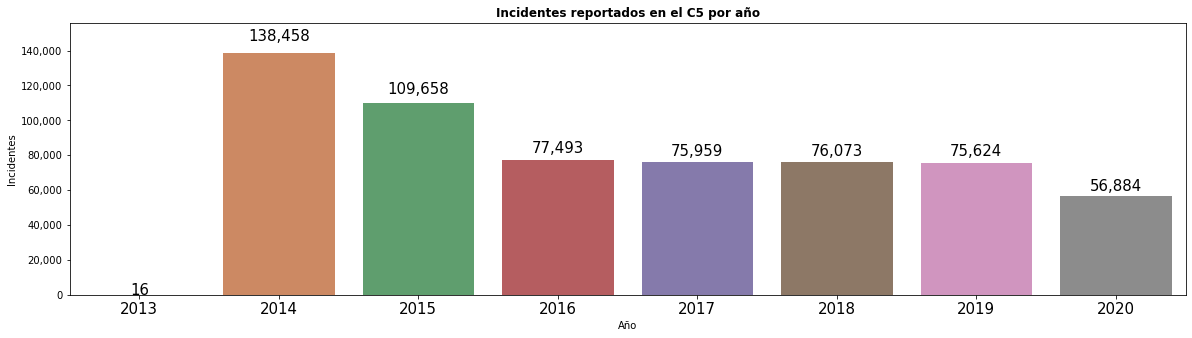

In [7]:
## Agrupamos las incidentes por año para conocer la frcuencia en cada uno de estos
anio_incidentes = incidentes.groupby([incidentes['fecha_hecho'].dt.year])[['incidente_c4']].count()

## Graficamos lo anterior
fig = plt.figure(figsize=(20, 5))

ax = fig.subplots(1, 1)

sns.barplot(x=anio_incidentes.index, y=anio_incidentes['incidente_c4'], palette="deep", ax=ax)

for tick in ax.get_xticklabels():
        tick.set_fontsize(15) 

for i, v in enumerate(anio_incidentes['incidente_c4']):
    
    ax.text(y= v + v/20, x= i, s='{:,.0f}'.format(v), horizontalalignment='center', fontsize=15)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

maxy = max(anio_incidentes['incidente_c4']) + max(anio_incidentes['incidente_c4'])/8
ax.set_ylim(0, maxy)

ax.set_title('Incidentes reportados en el C5 por año', fontweight="bold")
ax.set_ylabel('Incidentes')
ax.set_xlabel('Año')

plt.show()

Como podemos observar, en el 2013 casi no hay incidentes reportados y para el 2014 y 2015 se comienza a alimentar la base de datos con los incidentes. Para los años subsecuentes, al parecer hay un cambio metodológico, pero los incidentes se mantienen casi sin cambios de 2016 a 2019 y en 2020 aun no se reporta toda la información.

In [8]:
# Ahora exploramos la base por tipo de incidente
conteo_incidentes = incidentes.groupby(['incidente_c4'])[["id"]].count().reset_index()

## Renombramos columnas para visualización
conteo_incidentes.columns = ["incidente_c4", "conteo"]

conteo_incidentes["porcentaje"] = conteo_incidentes["conteo"] / conteo_incidentes["conteo"].sum()

conteo_incidentes.sort_values(by="conteo", inplace=True, ascending=False)

conteo_incidentes

,incidente_c4,conteo,porcentaje
2,accidente-choque sin lesionados,346339,0.567615
0,accidente-choque con lesionados,130512,0.213896
18,lesionado-atropellado,84015,0.137692
6,accidente-motociclista,22862,0.037469
12,accidente-volcadura,12289,0.020140
17,lesionado-accidente automovilístico,3297,0.005403
8,accidente-persona atrapada / desbarrancada,3161,0.005181
7,accidente-otros,1624,0.002662
14,cadáver-atropellado,1547,0.002535
3,accidente-ciclista,1383,0.002267


Los choques son los incidentes más reportados en el C5, pero veamos cómo se que se reportan por año, para conocer el comportamiento.

In [9]:
conteo_incidentes_anios = incidentes.copy()

conteo_incidentes_anios['mes_hecho'] = incidentes['fecha_hecho'].dt.month
conteo_incidentes_anios['anio_hecho'] = incidentes['fecha_hecho'].dt.year

conteo_incidentes_anios = pd.pivot_table(conteo_incidentes_anios, values=["mes_hecho"], index=['incidente_c4'],
                                         columns=["anio_hecho"], aggfunc = np.count_nonzero)


# Le damos formato
conteo_incidentes_anios.fillna(0, inplace=True)


conteo_incidentes_anios

mes_hecho                    \
anio_hecho                                         2013     2014     2015   
incidente_c4                                                                
accidente-choque con lesionados                     6.0  27154.0  22001.0   
accidente-choque con prensados                      0.0      0.0      0.0   
accidente-choque sin lesionados                     7.0  80387.0  66196.0   
accidente-ciclista                                  0.0      0.0      0.0   
accidente-ferroviario                               0.0      1.0      0.0   
accidente-monopatín                                 0.0      0.0      0.0   
accidente-motociclista                              0.0      0.0      0.0   
accidente-otros                                     0.0    401.0    398.0   
accidente-persona atrapada / desbarrancada          1.0    446.0    402.0   
accidente-vehiculo atrapado                         0.0      0.0      0.0   
accidente-vehiculo desbarrancado                    0.0      0.0      0.0   
accidente-vehículo atrapado-varado                  0.0      0.0      0.0   
accidente-volcadura                                 0.0   3704.0   2371.0   
cadáver-accidente automovilístico                   0.0    143.0    158.0   
cadáver-atropellado                                 0.0    339.0    299.0   
detención ciudadana-accidente automovilístico       0.0     11.0      5.0   
detención ciudadana-atropellado                     0.0     51.0     33.0   
lesionado-accidente automovilístico                 0.0   1083.0    878.0   
lesionado-atropellado                               2.0  24738.0  16917.0   
mi ciudad-calle-incidente de tránsito               0.0      0.0      0.0   
sismo-choque con lesionados                         0.0      0.0      0.0   
sismo-choque con prensados                          0.0      0.0      0.0   
sismo-choque sin lesionados                         0.0      0.0      0.0   
sismo-persona atropellada                           0.0      0.0      0.0   

                                                                          \
anio_hecho                                        2016     2017     2018   
incidente_c4                                                               
accidente-choque con lesionados                16332.0  16157.0  17132.0   
accidente-choque con prensados                     0.0    152.0    101.0   
accidente-choque sin lesionados                47866.0  43412.0  42084.0   
accidente-ciclista                                 0.0      0.0      0.0   
accidente-ferroviario                              0.0      4.0      5.0   
accidente-monopatín                                0.0      0.0      0.0   
accidente-motociclista                             0.0   4802.0   5063.0   
accidente-otros                                  293.0    230.0    144.0   
accidente-persona atrapada / desbarrancada       303.0    469.0    570.0   
accidente-vehiculo atrapado                        0.0     60.0    297.0   
accidente-vehiculo desbarrancado                   0.0     51.0     49.0   
accidente-vehículo atrapado-varado                 0.0      0.0      0.0   
accidente-volcadura                             1351.0   1291.0   1281.0   
cadáver-accidente automovilístico                134.0    138.0    114.0   
cadáver-atropellado                              217.0    178.0    181.0   
detención ciudadana-accidente automovilístico      2.0      7.0      4.0   
detención ciudadana-atropellado                   23.0     19.0     39.0   
lesionado-accidente automovilístico             1336.0      0.0      0.0   
lesionado-atropellado                           9636.0   8989.0   8832.0   
mi ciudad-calle-incidente de tránsito              0.0      0.0      0.0   
sismo-choque con lesionados                        0.0      0.0     31.0   
sismo-choque con prensados                         0.0      0.0      1.0   
sismo-choque sin lesionados                        0.0      0.0   

Podemos ver, que en algunos años no se contaron algunos incidentes, por lo que se infiere que hubo cambios metodológicos. Por ejemplo, en los accidente-ciclista se comenzaron a contabilizar en 2019.

In [10]:
## AHora vemos cúantos incidentes suceden a diario

# Lo primero que queremos contar los incidentes diarios
incidentes_diarios = incidentes.groupby(incidentes['fecha_hecho'].dt.date)[['id']].count().reset_index()

# Renombramos columnas
incidentes_diarios.columns = ['dia', 'conteo']


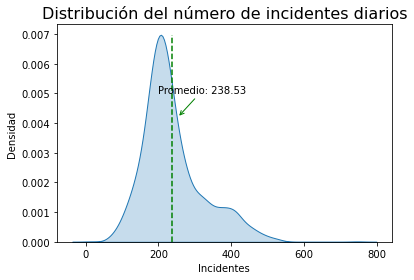

In [11]:
sns.kdeplot(data=incidentes_diarios['conteo'], shade=True)
plt.axvline(x=incidentes_diarios['conteo'].mean(), ymax=0.95, linestyle='--', color='green')
plt.annotate(
    'Promedio: ' + '{:,.2f}'.format(incidentes_diarios['conteo'].mean()),
    xy=(incidentes_diarios['conteo'].mean(), 0.004),
    xytext=(200, 0.005),
    arrowprops=dict(arrowstyle='->', color='green', shrinkB=10))
plt.title('Distribución del número de incidentes diarios', fontdict={'fontsize': 16})
plt.xlabel('Incidentes')
plt.ylabel('Densidad')
plt.show()

Hay una joroba en la parte derecha de la cola de la distrinución, probablemnte se deba al cambio metodológico que ya platicamos anteriormente. 

Pero en promedio, suceden en la Ciudad de México 238 incidentes diarios reportados al C5.

# 4. Presentación de resultados

### 4.1 Alcaldía con más eventos

Para este análisis, en la base contamos con información de la Alcaldía (Delegación) en donde inició el incidente, mediante la columna delegacion_inicio y que según el diccionario de datos mencionan que es "donde inicialmente se reportó el incidente". Mientras que en la columna de delegacion_cierre, se define como la Alcaldía donde cierra el folio del incidente.

Como en el diccionario de datos no se menciona cuál es la columna que es correcta para analizar los incidentes por Alcandía, se realizó un análisis en donde se comparó qué tanta diferencia tienen; es decir, cuantas observaciones mencionan que el incidente inició en una Alcaldía y cerró en otro.


In [12]:
incidentes['comprobacion'] = incidentes['delegacion_inicio'] == incidentes['delegacion_cierre']

procentaje_discr = (len(incidentes[incidentes['comprobacion'] == False]) / len(incidentes)) * 100

print("El {:,.2f}% de los datos discrepan entre la Alcaldía de inicio y de cierre".format(procentaje_discr))

incidentes = incidentes.drop(columns='comprobacion')

El 3.49% de los datos discrepan entre la Alcaldía de inicio y de cierre


La cifra anterior es muy baja para preocuparnos por estas discrepancias. Adicionalmente, hace más sentido analizar la alcaldía donde fue el hecho del incidente.


In [13]:
## Exploramos la incidencia de eventos por Alcaldía

## Agrupamos por alcaldía
incidentes_alcaldia = incidentes.groupby(['delegacion_inicio'])[['id']].count().reset_index()


## Renombramos columnas
incidentes_alcaldia.columns = ['alcaldia_hechos', 'conteo']

## Ordenamos
incidentes_alcaldia = incidentes_alcaldia.sort_values(by=['conteo'], ascending=False)

## Estimamos el porcentaje de incidentes totales por alcaldía
incidentes_alcaldia['porcentaje'] = (incidentes_alcaldia['conteo'] / incidentes_alcaldia['conteo'].sum())*100

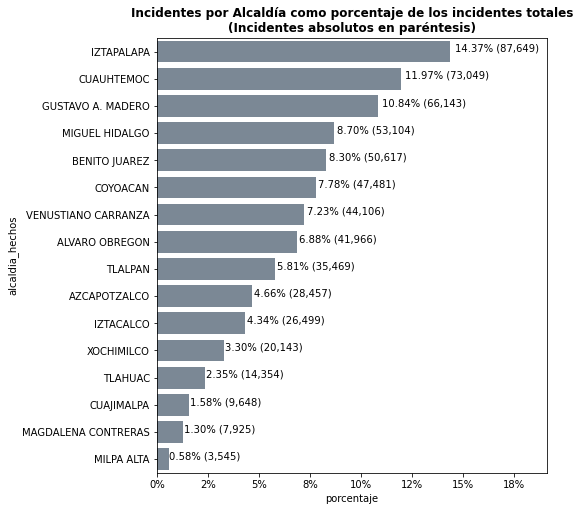

In [52]:
## Graficamos

fig = plt.figure(figsize=(7, 8))

ax = fig.subplots(1, 1)

sns.barplot(x="porcentaje", y="alcaldia_hechos", data=incidentes_alcaldia,
            label="Total", color="lightslategrey", ax=ax)


for i, (v, z) in enumerate(zip(incidentes_alcaldia['porcentaje'], incidentes_alcaldia['conteo'])):
    
    ax.text(x= v + v/60, y= i, s='{:,.2f}% ({:,.0f})'.format(v, z), horizontalalignment='left', fontsize=10)
    
for tick in ax.get_xticklabels():
        tick.set_fontsize(10) 

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}%'))

max_x = max(incidentes_alcaldia['porcentaje']) + max(incidentes_alcaldia['porcentaje'])/3
ax.set_xlim(0, max_x)

ax.set_title('Incidentes por Alcaldía como porcentaje de los incidentes totales\n(Incidentes absolutos en paréntesis)', fontweight="bold")

plt.show()

Como se puede observar en la gráfica anterior, el 14.37% de los incidentes totales, del año 2016 a la fecha, se han concentrado en la Alcaldía Iztapalapa, seguido por la Cuauhtémoc y la Gustavo A. Madero.


### 4.4.1 Visualización gráfica de los incidentes por Alcaldía

Para estos vamos a usar un archivo shapefile que dibuja los límites de las acladías de la Ciudad de México, y el cual se puede encontrar en la siguiente liga: https://datos.cdmx.gob.mx/dataset/limite-de-las-alcaldias


In [15]:
## Cargamos el shapefile
alcadias = gpd.read_file(r"mapa\limite-de-las-alcaldias.shp")

## Quitamos las observaciones que no cuentan con latitud ni longitud
gdf = incidentes[~incidentes['longitud'].isna()].copy()
gdf = gdf[~gdf['latitud'].isna()].copy()

## Creamos la base de datos para que lo pueda corre la paquetería de GeoPandas
gdf['Coordinates'] = list(zip(gdf['longitud'], gdf['latitud']))
gdf['Coordinates'] = gdf['Coordinates'].apply(Point)
gdf = gpd.GeoDataFrame(gdf, geometry='Coordinates', crs={'init': 'epsg:4326'})


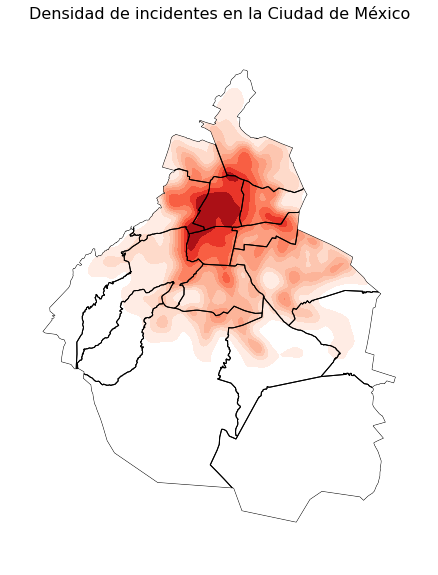

In [16]:
# Creamos una base de GeoPandas con las coordenadas de los delitos
fig = plt.figure(figsize=(10, 10))

ax = fig.subplots(1, 1)

gplt.kdeplot(gdf, cmap='Reds', shade=True, clip=alcadias, ax=ax)
gplt.polyplot(alcadias, zorder=1, ax=ax)
plt.title('Densidad de incidentes en la Ciudad de México', fontdict={'fontsize': 16})

plt.show()

## 4.2 Días con más incidentes

In [19]:
## Exploramos la incidencia de incidentes por día de la semana

# Creamos una copia de la base de datos
incidentes_dia = incidentes.copy()

incidentes_dia['dia_semana'] = incidentes['fecha_hecho'].dt.weekday
incidentes_dia['nombre_dia'] = incidentes['fecha_hecho'].dt.day_name()


## Agrupamos por día de la semana
incidentes_dia = incidentes_dia.groupby(["dia_semana", "nombre_dia"])[['id']].count().reset_index()


## Renombramos columnas
incidentes_dia.columns = ['dia_semana', 'nombre_dia', 'conteo']

## Ordenamos
incidentes_dia = incidentes_dia.sort_values(by=['dia_semana'], ascending=True)

## Estimamos el porcentaje de incidentes de ciclistas totales por alcaldía
incidentes_dia['porcentaje'] = (incidentes_dia['conteo'] / incidentes_dia['conteo'].sum())*100

## Cambiamos los nombres de los días en español
incidentes_dia['nombre_dia'].replace({"Monday": "Lunes",
                                      "Tuesday": "Martes",
                                      "Wednesday": "Miércoles",
                                      "Thursday": "Jueves",
                                      "Friday": "Viernes",
                                      "Saturday": "Sábado",
                                      "Sunday": "Domingo"}, 
                                    inplace=True)

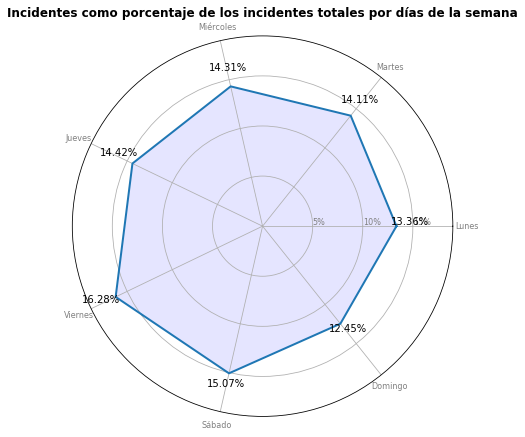

In [20]:
## Graficamos

categorias = list(incidentes_dia['nombre_dia'].unique())

N = len(categorias)
 
angulos = [n / float(N) * 2 * pi for n in range(N)]
angulos += angulos[:1]

valores = list(incidentes_dia['porcentaje'].copy())

valores += valores[:1]

fig = plt.figure(figsize=(7, 7))

ax = plt.subplot(polar=True)

plt.xticks(angulos[:-1], categorias, color='grey', size=8)

ax.set_rlabel_position(0)

plt.yticks([5,10,15], ["5%","10%","15%"], color="grey", size=8)

maxy = max(incidentes_dia['porcentaje']) + max(incidentes_dia['porcentaje'])/6

plt.ylim(0,maxy)

for i, (v, d) in enumerate(zip(valores[:-1], angulos[:-1])):
    
    ax.text(y= v + v/10, x= d, s='{:,.2f}%'.format(v), horizontalalignment='center',
            verticalalignment='bottom', fontsize=10)
    

ax.plot(angulos, valores, linewidth=2, linestyle='solid')

ax.fill(angulos, valores, 'b', alpha=0.1)

ax.set_title('Incidentes como porcentaje de los incidentes totales por días de la semana', fontweight="bold")


plt.show()

Podemos ver en la gráfica anterior que los viernes es donde se percibe mayor número de incidentes, con el 16.28% de los incidentes, seguido el día después y anterior, con el 15.07 y 14.42%, respectivamente.

También podemos ver que los domingos es en donde se registran el menos número de incidentes.


## 4.3 Hora con más incidentes

In [21]:
## Exploramos la incidencia de incidentes por hora

## Agrupamos por hora
incidentes_hora = incidentes.groupby(incidentes['hora_hecho'].dt.hour)[['id']].count().reset_index()


## Renombramos columnas
incidentes_hora.columns = ['hora_incidente', 'conteo']

## Ordenamos
incidentes_hora = incidentes_hora.sort_values(by=['hora_incidente'], ascending=False)

## Estimamos el porcentaje de incidentes por hora
incidentes_hora['porcentaje'] = (incidentes_hora['conteo'] / incidentes_hora['conteo'].sum())*100


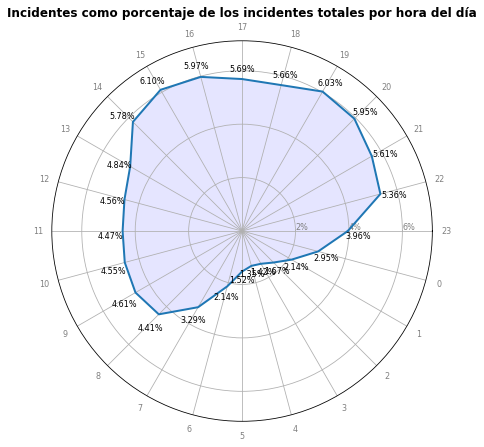

In [57]:
## Graficamos

categorias = list(incidentes_hora['hora_incidente'].unique())

N = len(categorias)
 
angulos = [n / float(N) * 2 * pi for n in range(N)]
angulos += angulos[:1]

valores = list(incidentes_hora['porcentaje'].copy())

valores += valores[:1]

fig = plt.figure(figsize=(7, 7))

ax = plt.subplot(polar=True)

plt.xticks(angulos[:-1], categorias, color='grey', size=8)

ax.set_rlabel_position(0)

plt.yticks([2,4,6, 8], ["2%","4%","6%", "8%"], color="grey", size=8)

maxy = max(incidentes_hora['porcentaje']) + max(incidentes_hora['porcentaje'])/6

plt.ylim(0,maxy)

for i, (v, d) in enumerate(zip(valores[:-1], angulos[:-1])):
    
    ax.text(y= v + v/10, x= d, s='{:,.2f}%'.format(v), horizontalalignment='center',
            verticalalignment='top', fontsize=8)
    

ax.plot(angulos, valores, linewidth=2, linestyle='solid')

ax.fill(angulos, valores, 'b', alpha=0.1)

ax.set_title('Incidentes como porcentaje de los incidentes totales por hora del día', fontweight="bold")


plt.show()

A las 15 horas del día es cuando se registran el mayor número de incidentes, concentrando el 6.10% de los incidentes, seguido por las 19 horas, con el 6.03% de los incidentes.

En las horas de la madrugada del día es cuando acontecen menos incidentes.

## 4.4 Calles con más incidentes

Vamos a utilizar la API Geocoding de Google Maps, la cual cuenta con la función reverse_geocode, que arroja el nombre de la calle con la información de latitud y longitud del incidente.

Asimismo, utilizaremos una muestra de la base de datos. Lo anterior, porque la API de Google limita a 2,500 solicitudes al día y pasando esas solicitudes cobra una tarifa, por lo que utilizaremos una muestra aleatoria del 1% de la base de datos de incidentes.


In [23]:
# Creamos la función que nos conecta a la API de google maps para buscar el nombre de la calle

def nombre_calle(lat, long):

    # Usamos la Key que tramitamos con google, la cual ocultaré por motivos de seguridad
    gmaps = googlemaps.Client(key='Key-Here')

    ## Utilizamos la geolocalización para extraer la infromación del punto
    reverse_geocode_result = gmaps.reverse_geocode((lat, long))

    df = pd.DataFrame.from_dict(pd.json_normalize(reverse_geocode_result), orient='columns')

    df['types'] = [','.join(map(str, l)) for l in df['types']]

    df = df.loc[df['types']=='route', 'address_components'].reset_index(drop=True)[0]

    df = pd.DataFrame.from_dict(pd.json_normalize(df), orient='columns')

    df['types'] = [','.join(map(str, l)) for l in df['types']]

    street_name = df.loc[df['types']=='route', 'short_name'].reset_index(drop=True)[0]

    return street_name

In [24]:
## Tomamos la muestra del 1% de la base de datos
## Primero quitamos las observaciones que no tienen información de geolocalización
incidentes_muestra = incidentes[~incidentes['longitud'].isna()]

## Elegimos la muestra aleatoria
incidentes_muestra = incidentes_muestra.sample(frac = 0.01, random_state = 42)

In [25]:
## Corremos la función de nombre_calle que creamos arriba para extraer el nombre de la calle de cada punto de geolocalización

## Ponemos una condicional para que no solicite información a la API si ya tenemos el archivo con el nombre de las calles

if r'incidentes_c5\incidentes_muestra_calle.xlsx' not in glob.glob(r'incidentes_c5\*'):
    
    #incidentes_muestra[incidentes_muestra['calle_incidente'].isna()]
    
    for index in incidentes_muestra.index:
        
        lat_ = incidentes_muestra.loc[index, 'latitud']
        
        long_ = incidentes_muestra.loc[index, 'longitud']

        incidentes_muestra.loc[index, 'calle_incidente'] = nombre_calle(lat_, long_)
        
    incidentes_muestra.to_excel(r'incidentes_c5\incidentes_muestra_calle.xlsx')
    
else:
    
    incidentes_muestra = pd.read_excel(r'incidentes_c5\incidentes_muestra_calle.xlsx')

In [26]:
incidentes_calle = incidentes_muestra.groupby(incidentes_muestra['calle_incidente'])[['id']].count().reset_index()

## Ordenamos
incidentes_calle = incidentes_calle.sort_values(by=['id'], ascending=False)

## Renombramos columnas
incidentes_calle.columns = ['calle_nombre', 'conteo']

## Estimamos el porcentaje de incidentes por hora
incidentes_calle['porcentaje'] = (incidentes_calle['conteo'] / incidentes_calle['conteo'].sum())*100


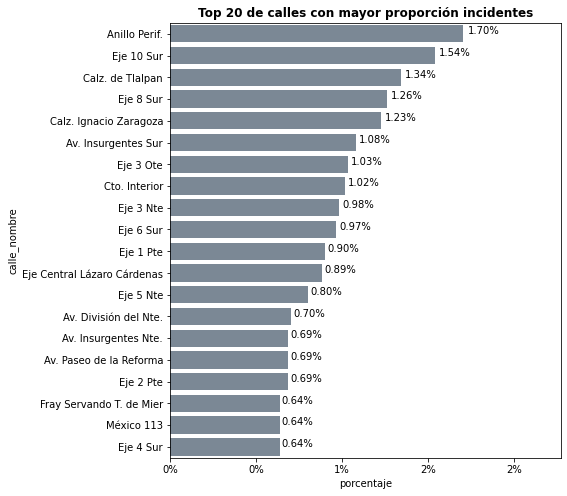

In [58]:
## Graficamos el top 20 de calles con más incidentes

incidentes_calle_top = incidentes_calle[0:20]

fig = plt.figure(figsize=(7, 8))

ax = fig.subplots(1, 1)

sns.barplot(x="porcentaje", y="calle_nombre", data=incidentes_calle_top,
            label="Total", color="lightslategrey", ax=ax)


for i, v in enumerate(incidentes_calle_top['porcentaje']):
    
    ax.text(x= v + v/60, y= i, s='{:,.2f}%'.format(v), horizontalalignment='left', fontsize=10)
    
for tick in ax.get_xticklabels():
        tick.set_fontsize(10) 

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}%'))

max_x = max(incidentes_calle_top['porcentaje']) + max(incidentes_calle_top['porcentaje'])/3
ax.set_xlim(0, max_x)

ax.set_title('Top 20 de calles con mayor proporción incidentes', fontweight="bold")

plt.show()

### 4.5 Esquinas en donde suceden más incidentes

Para estimar las esquinas con más incidentes, es necesario analizar la información de una base de datos con las principales vialidades de la Ciudad de México, en donde se buscaron las intersecciones entre esas vialidades y se encontró qué accidentes habían sucedido en esa intersección a través de los datos de latitud y longitud de la base de los incidentes


In [28]:
## Verificamos que la base de datos de las principales vialidades ya se encuentre en la carpeta
if r'incidentes_c5\vialidades-de-la-ciudad-de-mexico.csv' not in glob.glob(r'incidentes_c5\*'):
    
    print("Descargando base de principales vialidades...")

    enlace = 'https://datos.cdmx.gob.mx/dataset/b3514d29-dedc-4006-90f3-156e0c56fb90/resource/44bc1807-a7ba-44a0-bf46-504623a30905/download/vialidades-de-la-ciudad-de-mexico.csv'
    
    urllib.request.urlretrieve(enlace, r"incidentes_c5\vialidades-de-la-ciudad-de-mexico.csv")
    
    print("Descarga finalizada")
    
## Cargamos la base de datos
prin_vialidades = pd.read_csv(r'incidentes_c5\vialidades-de-la-ciudad-de-mexico.csv',
                         engine='python', encoding='utf_8')


In [29]:
list_lines = []

for index in prin_vialidades.index:
    
    # Extraemos de la celda el string que contiene el diccionario
    geo = prin_vialidades.loc[index, "geo_shape"]
    
    # Lo convertimos en diccionario
    converter_json = json.loads(geo)
    
    # Extraemos los puntos de cada dupla de coordenadas
    puntos = [Point(point) for point in converter_json['coordinates']]
    
    line = LineString(puntos)
    
    list_lines.append(line)
    
# Para generar el GeoDataFrame primer convertiremos la lista de LineStrings y el nombre de vialidades en un diccionario
geo_dict = {'nombre': list(prin_vialidades['nombre']), 'geometry': list_lines}

geodf_vialidades = gpd.GeoDataFrame(geo_dict, crs={'init': 'epsg:4326'})

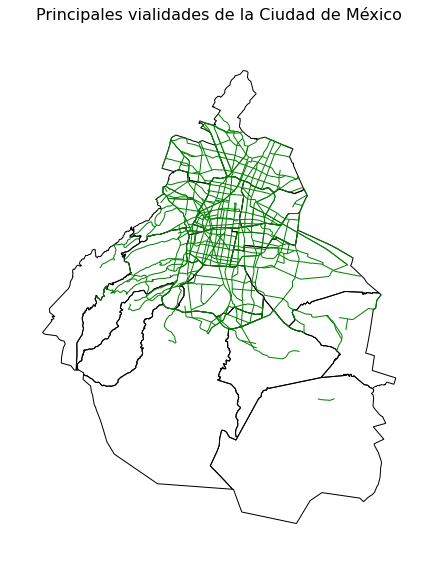

In [30]:
# Graficamos estas vialidades
fig = plt.figure(figsize=(10, 10))

ax = fig.subplots(1, 1)

geodf_vialidades.plot(ax=ax, color='green', linewidth=1)
gplt.polyplot(alcadias, zorder=1, ax=ax)
plt.title('Principales vialidades de la Ciudad de México', fontdict={'fontsize': 16})

plt.show()



Aquí podemos ver de manera gráfica, las principales vialidades de la Ciudad de México. Nuestro interés es poder tener información de los puntos donde estas vialidades se cruzan.

Para lo anterior, tenemos que estimar la latitud y la longitud en donde sucede cada una de las intersecciones.

Después, vamos a ver cuáles de los incidentes caen dentro del radio sobre cada uno de los puntos de las intersecciones.


In [31]:
lines = geodf_vialidades.index

inters = []
vialidad1 = []
vialidad2 = []


for line1, line2 in itertools.combinations(lines, 2):
    
    if geodf_vialidades.loc[line1, 'geometry'].intersects(geodf_vialidades.loc[line2, 'geometry']):
        
        inter = geodf_vialidades.loc[line1, 'geometry'].intersection(geodf_vialidades.loc[line2, 'geometry'])
    
        if "Point" == inter.type:

            inters.append(inter)
            
            vialidad1.append(geodf_vialidades.loc[line1, 'nombre'])
            vialidad2.append(geodf_vialidades.loc[line2, 'nombre'])
        

In [32]:
# Convertimos los puntos en un GeoDataFrame
geo_dict_inter = {'geometry': inters, 'validad1': vialidad1, 'validad2': vialidad2}

geo_dict_inter = gpd.GeoDataFrame(geo_dict_inter, crs={'init': 'epsg:4326'})

In [33]:
# Tenemos que reproyectar la información geodésica para que sea leible en metros 
reproj_points = geo_dict_inter.to_crs({'init': 'EPSG:4485'})

reproj_vialidades = geodf_vialidades.to_crs({'init': 'EPSG:4485'})

reproj_alcadias = alcadias.to_crs({'init': 'EPSG:4485'})

# Transformamos también la base con los punyos donde sucedieron los incidentes
reproj_gdf = gdf[['Coordinates']].to_crs({'init': 'EPSG:4485'}).to_crs({'init': 'EPSG:4485'})

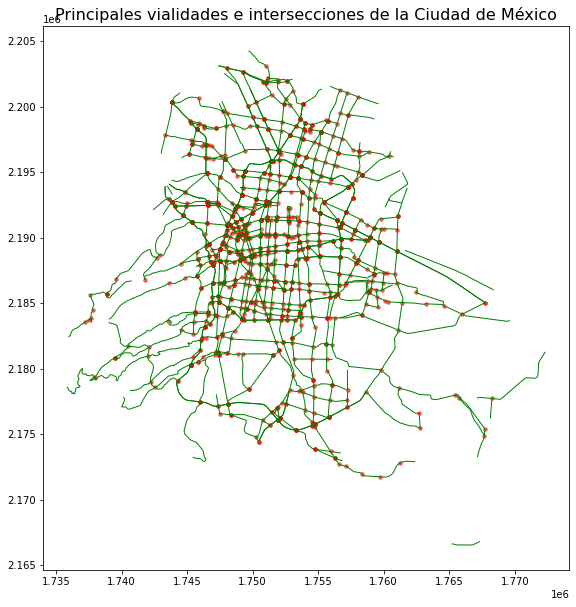

In [34]:
# Graficamos estas vialidades
fig = plt.figure(figsize=(10, 10))

ax = fig.subplots(1, 1)

reproj_vialidades.plot(ax=ax, color='green', linewidth=1)
plt.title('Principales vialidades e intersecciones de la Ciudad de México', fontdict={'fontsize': 16})

reproj_points.plot(ax=ax, linewidths=3, markersize=2, color='red', alpha=.7)


plt.show()


Una vez encontrado los puntos donde suceden las intersecciones, así como su latitud y longitud, vamos a iterar con la información de los incidentes, para encontrar cuáles de estos caen dentro del radio de los puntos de intersección


In [35]:
# Por cad intersección, hacemos una circunferencia de 30 metros, con el fin de capturar los incidentes 
# que sucedieron en ese espacio
buffer_inter = reproj_points.geometry.buffer(30)

reproj_points['buffer'] = buffer_inter

reproj_points['esquina'] = reproj_points['validad1']  + " - " + reproj_points['validad2'] 

In [36]:
esquinas = pd.DataFrame({"geometry": [], "esquina": []})

indice = reproj_points.index

for i in tqdm(indice):

    for point in list(reproj_gdf['Coordinates']):
    
        if point.within(reproj_points.loc[i, 'buffer']):
            
            df = pd.DataFrame({"geometry": [point], 
                               "esquina": [reproj_points.loc[i, 'esquina']]})
            
            esquinas = pd.concat([df, esquinas])

100%|██████████| 1433/1433 [3:25:54<00:00,  8.62s/it]  


In [37]:
# Agrupamos las esquinas para contabilizar en donde suceden más accidentes
esquinas_agg = esquinas.groupby(['esquina'])[['geometry']].count().reset_index()

## Renombramos columnas
esquinas_agg.columns = ['esquina', 'conteo']


## Ordenamos
esquinas_agg = esquinas_agg.sort_values(by=['conteo'], ascending=False)


## Estimamos el porcentaje de incidentes de ciclistas totales por alcaldía
esquinas_agg['porcentaje'] = (esquinas_agg['conteo'] / 
                              esquinas_agg['conteo'].sum())*100

esquinas_agg[0:20]

,esquina,conteo,porcentaje
229,Av. de los Insurgentes Sur - Anillo Periferico...,2418,0.919476
1159,Viaducto Tlalpan - Anillo Periferico Boulevard...,2268,0.862436
471,Circuito Interior Rio Mixcoac - Circuito Inter...,1772,0.673826
411,Circuito Interior Instituto Tecnico Industrial...,1548,0.588647
1121,Paseo del Pedregal - Anillo Periferico Bouleva...,1516,0.576478
62,Av. Aquiles Serdan - Av. Aquiles Serdan,1496,0.568873
64,Av. Aquiles Serdan - Av. Tezozomoc,1496,0.568873
451,Circuito Interior Rio Churubusco - Calzada de ...,1292,0.491300
434,Circuito Interior Melchor Ocampo - Av. Parque Via,1246,0.473807
763,Eje 3 Oriente Av. Azucar - Viaducto Rio de la ...,1216,0.462400


La esquina de Circuito Interior Rio Mixcoac con Circuito Interior Rio Churubusco es en donde más se han contabilizado incidentes


In [38]:
esquinas_agg.to_excel(r"incidentes_c5\esquinas.xlsx")

In [39]:
# Vamos a transformar la información para hacer una gráfica con un top de las esquinas más peligtrosas y un mapa
esquinas_unique = esquinas.drop_duplicates(subset='esquina')

# Unimos las bases para tener una sola con la información de la frecuencia y el Point
esquinas_final = esquinas_agg.merge(esquinas_unique[['geometry', 'esquina']], 
                                 on='esquina',
                                 how='left')

In [40]:
# Convertimos los puntos en un GeoDataFrame
dict_esquinas =  {'geometry': list(esquinas_final['geometry']), 
                  'conteo': list(esquinas_final['conteo']),
                  'porcentaje': list(esquinas_final['porcentaje']),
                  'esquina': list(esquinas_final['esquina'])}

dict_esquinas = gpd.GeoDataFrame(dict_esquinas, crs={'init': 'epsg:4485'})

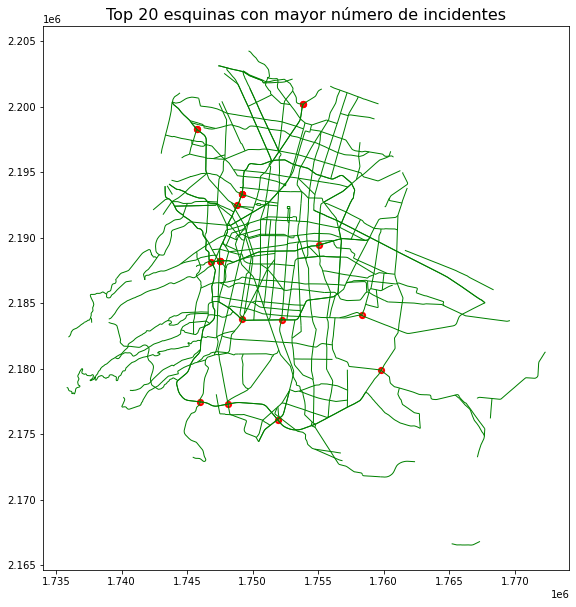

In [41]:
# Graficamos estas vialidades
fig = plt.figure(figsize=(10, 10))

ax = fig.subplots(1, 1)

reproj_vialidades.plot(ax=ax, color='green', linewidth=1)
#gplt.polyplot(reproj_alcadias, zorder=1, ax=ax)
dict_esquinas[0:20].plot(ax=ax, linewidths=5, markersize=5, color='red', alpha=1)
plt.title('Top 20 esquinas con mayor número de incidentes', fontdict={'fontsize': 16})

plt.show()

